In [4]:
# Import packages
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import calendar
import time
months = [month.lower() for month in calendar.month_name[1:]]

In [71]:
def streak(results_list) :

    streak_type, current_res = results_list[0], results_list[0]
    streak = 1
    streaks = [results_list[0]]
    for res in results_list[1:] :
        if res == current_res:
            streak += 1
        else :
            streak = 1
            streak_type = res
        streaks.append(streak * streak_type)
        current_res = res
        
    return [np.nan] + streaks[:-1]

def keep_unique(df) :
    if len(df) == 1 :
        return df
    else :
        return df[df['Tm'] == 'TOT']

In [72]:
year = 2023

url = f'https://www.basketball-reference.com/leagues/NBA_{year}_ratings.html'
soup = BeautifulSoup(requests.get(url).content, 'lxml')
soup.find('tr', class_='over_header').decompose()
table = soup.find('table')
teams_dict = pd.read_html(str(table))[0][['Team', 'W', 'L']]
teams_dict['code'] = [x['href'].split('/')[2] for x in table.find_all('a', href = True)]
ngames_dict = dict(zip(teams_dict['code'], teams_dict['W'] + teams_dict['L']))
teams_dict  = dict(zip(teams_dict['Team'], teams_dict['code']))

url = f'https://www.basketball-reference.com/leagues/NBA_{year}_games.html'
soup = BeautifulSoup(requests.get(url).content, 'lxml')
monthly_url = [x['href'] for x in soup.find_all('a', href = True) if x['href'].split('.html')[0].split('-')[-1] in months]
while soup.find('tr', class_ = 'thead') is not None:
    soup.find('tr', class_ = 'thead') .decompose()

games = pd.read_html(str(soup.find('table')))[0]
games['href'] = [x['href'] for x in soup.find('table').find_all('a', href = True) if 'boxscores' in x['href'] and 'html' in x['href']]

for m_url in monthly_url[1:]:

    url = 'https://www.basketball-reference.com/' + m_url
    soup = BeautifulSoup(requests.get(url).content, 'lxml')
    m_games = pd.read_html(str(soup.find('table')))[0]
    m_games['href'] = [x['href'] for x in soup.find('table').find_all('a', href = True) if 'boxscores' in x['href'] and 'html' in x['href']]
    games = pd.concat([games, m_games])

games = games.rename(columns = {'Start (ET)':'Time', 'Visitor/Neutral':'Away', 'Home/Neutral':'Home', 'PTS':'PTS_away', 'PTS.1':'PTS_home'})
games['Date'] = games['Date'] + games['Time'].apply(lambda x: ' ' + x[:-1] + x[-1].upper() + 'M')
games['Date'] = pd.to_datetime(games['Date'])
games = games[['Date', 'Home', 'Away', 'href', 'PTS_home', 'PTS_away']]
games = games.sort_values('Date').reset_index(drop = True)
games['Home'] = games['Home'].apply(lambda x: teams_dict.get(x))
games['Away'] = games['Away'].apply(lambda x: teams_dict.get(x))

In [179]:
homes, aways = [], []

for tm in list(teams_dict.values()) :

    games_tm = games.copy()[(games['Home'] == tm) | (games['Away'] == tm)]
    games_tm['Home?'] = 1 * (games_tm['Home'] == tm)
    games_tm['Opponent'] = (games_tm['Home?'] * games_tm['Away'] + (1 - games_tm['Home?']) * games_tm['Home'])
    games_tm['PTS'] = (games_tm['Home?'] * games_tm['PTS_home'] + (1 - games_tm['Home?']) * games_tm['PTS_away'])
    games_tm['PTS_opp'] = (games_tm['Home?'] * games_tm['PTS_away'] + (1 - games_tm['Home?']) * games_tm['PTS_home'])
    games_tm['W'] = (games_tm['PTS'] > games_tm['PTS_opp']).astype(int)
    games_tm['Team'] = len(games_tm) * [tm]
    games_tm = games_tm.head(ngames_dict.get(tm))
    games_tm = games_tm.sort_values('Date').reset_index(drop = True)
    games_tm['G'] = games_tm.index + 1
    games_tm = games_tm[['Date', 'href', 'Team', 'Opponent', 'G', 'Home?', 'PTS', 'PTS_opp', 'W']]

    features = []
    games_tm['NRtg'] = (games_tm['PTS'] - games_tm['PTS_opp']).rolling(1000, min_periods = 1).mean().shift(1)
    features.append('NRtg')
    for lag in [5, 10, 25] :
        games_tm[f'NRtg_{lag}'] = (games_tm['PTS'] - games_tm['PTS_opp']).rolling(lag, min_periods = 1).mean().shift(1)
        features.append(f'NRtg_{lag}')

    games_tm['W/L'] = games_tm['W'].rolling(1000, min_periods = 1).mean().shift(1)
    features.append('W/L')
    for lag in [5, 10, 25] :
        games_tm[f'W/L_{lag}'] = games_tm['W'].rolling(lag, min_periods = 1).mean().shift(1)
        features.append(f'W/L_{lag}')

    games_tm['Streak'] = streak(games_tm['W'].replace(0, -1))
    features.append('Streak')

    games_tm['Rest'] = (games_tm['Date'] - games_tm['Date'].shift(1)).apply(lambda x: x.total_seconds() / (24 * 3600))
    features.append('Rest')

    games_tm_home = games_tm.groupby('Home?').get_group(1)
    for f in ['G', 'W'] + features :
        games_tm_home = games_tm_home.rename(columns = {f : f + '_home'})
    games_tm_home = games_tm_home.rename(columns = {'Team': 'Home', 'Opponent': 'Away', 'PTS': 'PTS_home', 'PTS_opp': 'PTS_away'})

    games_tm_away = games_tm.groupby('Home?').get_group(0)
    for f in ['G', 'W'] + features :
        games_tm_away = games_tm_away.rename(columns = {f : f + '_away'})
    games_tm_away = games_tm_away.rename(columns = {'Team': 'Away', 'Opponent': 'Home', 'PTS': 'PTS_away', 'PTS_opp': 'PTS_home'})

    homes.append(games_tm_home)
    aways.append(games_tm_away)

In [182]:
# Get all home stats and away stats in single DataFrame
homes_df = pd.concat(homes).drop(columns = 'Home?')
aways_df = pd.concat(aways).drop(columns = ['Home?'])
    
# Merge away and home games on the unique game ID
data = homes_df.merge(aways_df, on = ['Date', 'href', 'Home', 'Away', 'PTS_home', 'PTS_away'])
data['PTS_diff'] = data['PTS_home'] - data['PTS_away']
data = data.sort_values('Date').reset_index(drop = True)

In [239]:
data.columns

Index(['Date', 'href', 'Home', 'Away', 'G_home', 'PTS_home', 'PTS_away',
       'W_home', 'NRtg_home', 'NRtg_5_home', 'NRtg_10_home', 'NRtg_25_home',
       'W/L_home', 'W/L_5_home', 'W/L_10_home', 'W/L_25_home', 'Streak_home',
       'Rest_home', 'G_away', 'W_away', 'NRtg_away', 'NRtg_5_away',
       'NRtg_10_away', 'NRtg_25_away', 'W/L_away', 'W/L_5_away', 'W/L_10_away',
       'W/L_25_away', 'Streak_away', 'Rest_away', 'PTS_diff'],
      dtype='object')

In [228]:
ratings = pd.read_csv('/Users/martinbogaert/Desktop/will-the-knicks-win-tonight/player_ratings.csv')

In [234]:
def get_lineup_score(game_url, home, away, year, ratings) :

    url = 'https://www.basketball-reference.com/' + game_url
    soup = BeautifulSoup(requests.get(url).content, 'lxml')
    tables = soup.find_all('table')
    ha_avg_rating = []

    for ha in [home, away] :

        table = tables[np.where([f'{ha}-game-basic' in t.get('id') for t in tables])[0][0]]
        table.find(class_ = 'over_header').decompose()
        while table.find(class_ = 'thead') is not None:
            table.find(class_ = 'thead').decompose()

        boxscore = pd.read_html(str(table))[0][:-1].rename(columns = {'Starters': 'Player'})
        boxscore['MP'] = boxscore['MP'].replace('Did Not Play', '0:00')
        boxscore['MP'] = boxscore['MP'].apply(lambda x: int(x.split(':')[0]) + float(x.split(':')[-1]) / 60)
        boxscore['ID'] = [x['href'].split('/')[-1].split('.')[0] for x in table.find_all('a', href = True) if 'player' in x['href']]
        boxscore['Year'] = len(boxscore) * [year]
        boxscore = boxscore[['Player', 'ID', 'Year', 'MP']]

        boxscore = boxscore.merge(ratings.drop(columns = ['Player', 'G', 'MP']), on = ['ID', 'Year'])

        ha_avg_rating.append(sum(boxscore.rVORP * boxscore.MP) / sum(boxscore.MP))

    return ha_avg_rating

In [235]:
ha_avg_ratings = []
for game_url, home, away in zip(data['href'], data['Home'], data['Away']) :
    ha_avg_ratings.append(get_lineup_score(game_url, home, away, 2023, ratings))

KeyboardInterrupt: 

In [236]:
ha_avg_ratings

[[0.6651560347109565, 0.8374094097916213],
 [0.21615413582645487, 0.3074205441813671],
 [-0.1384012102973623, 0.08459720684023453]]

In [243]:
ex = data.head(3)
ex[['a', 'b']] = ha_avg_ratings

/var/folders/x8/gymrgfns32bd6rd_ksf19p3m0000gn/T/ipykernel_49095/3905675362.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ex[['a', 'b']] = ha_avg_ratings
/var/folders/x8/gymrgfns32bd6rd_ksf19p3m0000gn/T/ipykernel_49095/3905675362.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ex[['a', 'b']] = ha_avg_ratings


In [244]:
ex

,Date,href,Home,Away,G_home,PTS_home,PTS_away,W_home,NRtg_home,NRtg_5_home,...,NRtg_25_away,W/L_away,W/L_5_away,W/L_10_away,W/L_25_away,Streak_away,Rest_away,PTS_diff,a,b
0,2022-10-18 19:30:00,/boxscores/202210180BOS.html,BOS,PHI,1,126,117,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,0.665156,0.837409
1,2022-10-18 22:00:00,/boxscores/202210180GSW.html,GSW,LAL,1,123,109,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,0.216154,0.307421
2,2022-10-19 19:00:00,/boxscores/202210190IND.html,IND,WAS,1,107,114,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7,-0.138401,0.084597


In [94]:
dfs = []
years = np.arange(1980, 2024)

for year in years :
    print(year)
    url = f'https://www.basketball-reference.com/leagues/NBA_{year}_advanced.html'
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html')
    table = soup.find('table')
    df = pd.read_html(str(table))[0]
    df = df[df['Player'] != 'Player']
    df['ID'] = [x['href'].split('/')[-1].split('.')[0] for x in table.find_all('a', href = True) if 'players' in x['href']]
    df = df.groupby('Player').apply(keep_unique).reset_index(drop = True)
    for f in ['G', 'MP', 'PER', 'BPM', 'VORP'] :
        df[f] = pd.to_numeric(df[f])
    df['Year'] = [year] * len(df)
    df = df[['Player', 'ID', 'Year', 'G', 'MP', 'PER', 'BPM', 'VORP']]
    dfs.append(df)
    time.sleep(3)

1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


In [122]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

stats = pd.concat(dfs).reset_index(drop = True)
stats['PER'] = stats['PER'].fillna(stats['PER'].mean())
stats_clean = stats[stats['MP'] >= 500]
scaler, pca = StandardScaler(), PCA(n_components = 1)

In [123]:
X_norm = scaler.fit_transform(stats_clean[['PER', 'BPM', 'VORP']])
pca.fit(X_norm)

stats[['PER', 'BPM', 'VORP']] = scaler.transform(stats[['PER', 'BPM', 'VORP']])
stats['SKILL'] = pca.transform(np.array(stats[['PER', 'BPM', 'VORP']]))

In [148]:
def get_rating(stats, id_, year) :

    stats_player = stats.groupby('ID').get_group(id_)
    stats_player = stats_player[stats_player['Year'] <= year]

    if len(stats_player) == 1 :
     
         return stats_player['VORP'].to_list()[0], stats_player['SKILL'].to_list()[0]

    else :
         years = np.array(stats_player['Year'])
         alphas = 1 / 3 ** (year - years)

         vorp  = sum(stats_player['VORP'] * alphas) / sum(alphas)
         skill = sum(stats_player['SKILL'] * alphas) / sum(alphas)

         return vorp, skill

In [150]:
ratings = [get_rating(stats, id_, year) for id_, year in zip(stats['ID'], stats['Year'])]

In [245]:
features

['NRtg',
 'NRtg_5',
 'NRtg_10',
 'NRtg_25',
 'W/L',
 'W/L_5',
 'W/L_10',
 'W/L_25',
 'Streak',
 'Rest']

In [249]:
for f in features :

    data[f] = data[f'{f}_home'] - data[f'{f}_away']
    data = data.drop(columns = [f'{f}_home', f'{f}_away'])

In [250]:
data

,Date,href,Home,Away,G_home,PTS_home,PTS_away,W_home,G_away,W_away,...,NRtg,NRtg_5,NRtg_10,NRtg_25,W/L,W/L_5,W/L_10,W/L_25,Streak,Rest
0,2022-10-18 19:30:00,/boxscores/202210180BOS.html,BOS,PHI,1,126,117,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-10-18 22:00:00,/boxscores/202210180GSW.html,GSW,LAL,1,123,109,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-10-19 19:00:00,/boxscores/202210190IND.html,IND,WAS,1,107,114,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-10-19 19:00:00,/boxscores/202210190DET.html,DET,ORL,1,113,109,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-10-19 19:30:00,/boxscores/202210190BRK.html,BRK,NOP,1,108,130,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,2023-04-09 15:30:00,/boxscores/202304090LAL.html,LAL,UTA,82,128,117,1,82,0,...,1.259259,13.8,14.3,8.08,0.061728,0.6,0.6,0.28,0.0,0.708333
1226,2023-04-09 15:30:00,/boxscores/202304090PHO.html,PHO,LAC,82,114,119,0,82,1,...,1.716049,4.6,1.8,2.96,0.024691,0.2,0.1,0.08,-3.0,0.729167
1227,2023-04-09 15:30:00,/boxscores/202304090DEN.html,DEN,SAC,82,109,95,1,82,0,...,0.345679,-8.4,-4.2,-2.44,0.049383,-0.2,0.0,-0.08,-1.0,-0.729167
1228,2023-04-09 15:30:00,/boxscores/202304090POR.html,POR,GSW,82,101,157,0,82,1,...,-4.506173,-20.4,-20.4,-14.52,-0.123457,-0.6,-0.5,-0.36,-5.0,-0.750000


In [267]:
pd.Series(['1:22', '21:75', 'Did']).apply(lambda x: int(x.split(':')[0]) + float(x.split(':')[-1]) / 60 if ':' in x else 0)

0     1.366667
1    22.250000
2     0.000000
dtype: float64

In [269]:
df = pd.read_csv('/Users/martinbogaert/Desktop/will-the-knicks-win-tonight/training_data_2023.csv')

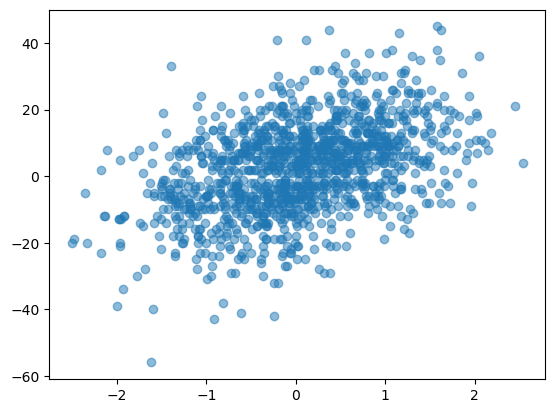

In [273]:
plt.scatter(df.rSKILL, df.PTS_diff, alpha = 0.5)

In [288]:
df.sort_values('rVORP', ascending = False).head(10)

,Date,href,Home,Away,G_home,PTS_home,PTS_away,W_home,G_away,W_away,...,NRtg_10,NRtg_25,W/L,W/L_5,W/L_10,W/L_25,Streak,Rest,rVORP,rSKILL
855,2023-02-13 19:00:00,/boxscores/202302130CLE.html,CLE,SAS,60,117,109,1,58,0,...,29.4,16.560000,0.381505,1.0,0.8,0.440000,18.0,-0.020833,1.323875,2.148609
257,2022-11-22 21:00:00,/boxscores/202211220DEN.html,DEN,DET,17,108,110,0,19,1,...,10.7,9.166667,0.458333,0.4,0.5,0.458333,8.0,-0.062500,1.284052,1.973791
1172,2023-04-02 20:00:00,/boxscores/202304020CLE.html,CLE,IND,79,115,105,1,79,0,...,13.7,12.360000,0.179487,0.4,0.3,0.280000,-3.0,-0.020833,1.278200,1.938247
1200,2023-04-06 22:00:00,/boxscores/202304060PHO.html,PHO,DEN,80,119,115,1,80,0,...,4.3,2.760000,-0.101266,0.6,0.1,0.040000,7.0,-0.083333,1.252572,2.537475
506,2022-12-27 19:30:00,/boxscores/202212270BOS.html,BOS,HOU,35,126,102,1,34,0,...,3.0,11.400000,0.402852,0.2,0.1,0.360000,1.0,1.125000,1.228336,1.935645
1187,2023-04-04 22:00:00,/boxscores/202304040PHO.html,PHO,SAS,79,115,94,1,79,0,...,17.8,16.280000,0.294872,0.8,0.4,0.400000,4.0,-0.041667,1.211776,2.457426
608,2023-01-09 21:00:00,/boxscores/202301090DEN.html,DEN,LAL,40,122,109,1,41,0,...,7.0,3.000000,0.191667,-0.2,0.2,0.120000,-3.0,1.041667,1.210822,2.179276
27,2022-10-22 18:00:00,/boxscores/202210220PHI.html,PHI,SAS,3,105,114,0,3,1,...,6.5,6.500000,-0.500000,-0.5,-0.5,-0.500000,-3.0,0.979167,1.208762,1.961272
858,2023-02-13 19:00:00,/boxscores/202302130PHI.html,PHI,HOU,56,123,104,1,57,0,...,9.3,13.240000,0.422403,0.6,0.4,0.560000,7.0,-0.916667,1.204723,2.011326
1087,2023-03-22 20:00:00,/boxscores/202303220MIL.html,MIL,SAS,72,130,94,1,73,0,...,10.5,20.280000,0.454421,0.2,0.3,0.680000,2.0,2.000000,1.129180,2.050852


In [ ]:
url = 'https://www.basketball-reference.com/boxscores/202102170BOS.html'
soup = BeautifulSoup(requests.get(url).content, 'lxml')
tables = soup.find_all('table')


table = tables[np.where([f'ATL-game-basic' in t.get('id') for t in tables])[0][0]]
table.find(class_ = 'over_header').decompose()
while table.find(class_ = 'thead') is not None:
    table.find(class_ = 'thead').decompose()

boxscore = pd.read_html(str(table))[0][:-1].rename(columns = {'Starters': 'Player'})
boxscore['MP'] = boxscore['MP'].replace('Did Not Play', '0:00').replace('Did Not Dress', '0:00').replace('Not With Team', '0:00')
boxscore['MP'] = boxscore['MP'].apply(lambda x: int(x.split(':')[0]) + float(x.split(':')[-1]) / 60 if ':' in x else 0)
boxscore['ID'] = [x['href'].split('/')[-1].split('.')[0] for x in table.find_all('a', href = True) if 'player' in x['href']]
boxscore['Year'] = len(boxscore) * [year]
boxscore = boxscore[['Player', 'ID', 'Year', 'MP']]

In [6]:
url = 'https://www.basketball-reference.com/boxscores/202102170BOS.html'
soup = BeautifulSoup(requests.get(url).content, 'lxml')
tables = soup.find_all('table')


table = tables[np.where([f'BOS-game-basic' in t.get('id') for t in tables])[0][0]]

In [7]:
table.find(class_ = 'over_header').decompose()
while table.find(class_ = 'thead') is not None:
    table.find(class_ = 'thead').decompose()

boxscore = pd.read_html(str(table))[0][:-1].rename(columns = {'Starters': 'Player'})

In [54]:
url = ""

url = "https://www.rotowire.com/baseball/daily-lineups.php"
response = requests.get(url)
html = response.text.replace("<!--", "").replace("-->", "")  # uncomment tables
soup = BeautifulSoup(html, "html.parser")

In [64]:
abr = []
for game in soup.find_all('div', {'class': 'lineup is-mlb has-started'}) + soup.find_all('div', {'class': 'lineup is-mlb'}):

    away, home = [x.text for x in game.find('div', {'class': 'lineup__teams'}).find_all('div', {'class': 'lineup__abbr'})]

    lineups = game.find('div', {'class': 'lineup__main'})

    

    starters = [x.text for x in lineups.find('ul', {'class': 'lineup__list is-visit'}).find_all('a')]
   # for team in game.find_all('div', {'class': 'lineup__top'}):

    #    abr.append([tm.text for tm in team.find_all('div', {"class": "lineup__abbr"})])

In [65]:
starters

['Jesus Luzardo',
 'Luis Arraez',
 'Jorge Soler',
 'Josh Bell',
 'J. Chisholm',
 'Jake Burger',
 'B. De La Cruz',
 'J. Sanchez',
 'Jon Berti',
 'Nick Fortes']

In [66]:
url = "https://www.rotowire.com/basketball/ratings.php"
response = requests.get(url)
html = response.text.replace("<!--", "").replace("-->", "")  # uncomment tables
soup = BeautifulSoup(html, "html.parser")

In [86]:
cities = pd.read_csv('uscities.csv')
cities = cities[cities['population'] > 10000]

In [88]:
pd.DataFrame([' '.join(name.split(' ')[:-1]) for name in teams_dict.keys()], columns = ['city']).merge(cities, on = 'city', how = 'left')[['city', 'lat', 'lng']]

,city,lat,lng
0,Boston,42.3188,-71.0852
1,Cleveland,41.4764,-81.6805
2,Cleveland,35.1817,-84.8707
3,Cleveland,33.7440,-90.7285
4,Philadelphia,40.0077,-75.1339
5,Memphis,35.1087,-89.9663
6,Memphis,27.5435,-82.5608
7,Milwaukee,43.0642,-87.9675
8,New York,40.6943,-73.9249
9,Denver,39.7620,-104.8758


In [133]:
team_location = pd.DataFrame(teams_dict.items(), columns = ['Team', 'Tm'])

In [154]:
city_state = {}
for tm in team_location['Tm']:

    if tm != 'NOP' and tm != 'BRK':
        url = f'https://www.basketball-reference.com/teams/{tm}/'
        soup = BeautifulSoup(requests.get(url).content, 'html')
        city, state = str(soup.find('div', {'id': 'info'})).split('Location:</strong>')[-1].split('</p>')[0].split('\n')[1][2:].split(', ')
        city_state[city] = state
        time.sleep(1)

IndexError: list index out of range

In [166]:
loc = pd.DataFrame(city_state.items(), columns = ['city', 'state_name']).merge(cities, on = ['city', 'state_name'], how = 'left')[['city', 'state_name', 'lat', 'lng']]

In [167]:
import matplotlib.pyplot as plt

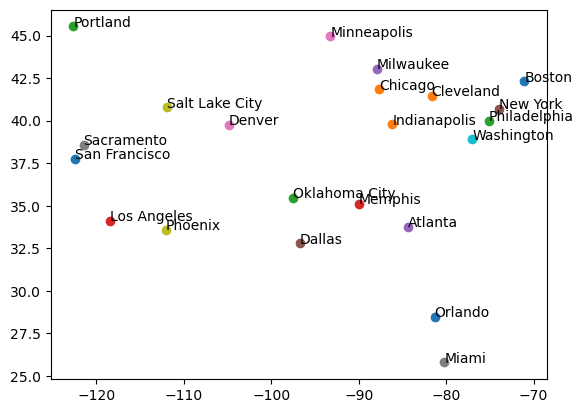

In [173]:
for L, l, name in zip(loc.lat, loc.lng, loc.city) :

    plt.scatter(l, L)
    plt.annotate(name, xy = (l,L))

In [32]:
# Define useful functions
def streak(results_list) :

    streak_type, current_res = results_list[0], results_list[0]
    streak = 1
    streaks = [results_list[0]]
    for res in results_list[1:] :
        if res == current_res:
            streak += 1
        else :
            streak = 1
            streak_type = res
        streaks.append(streak * streak_type)
        current_res = res
        
    return [np.nan] + streaks[:-1]

def keep_unique(df) :
    if len(df) == 1 :
        return df
    else :
        return df[df['Tm'] == 'TOT']

In [3]:
pd.read_csv('/Users/martinbogaert/Desktop/will-the-knicks-win-tonight/player_ratings.csv')

,Player,href,Year,Pos,Age,Tm,G,GS,MP,FG,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Kareem Abdul-Jabbar,abdulka01,1979,C,31,LAL,80,NaN,39.5,9.7,...,15.3,23.3,8.8,5.6,14.4,0.219,4.6,3.0,7.6,7.7
1,Tom Abernethy,abernto01,1979,PF,24,GSW,70,NaN,17.4,2.5,...,7.7,13.8,2.3,1.3,3.7,0.144,0.2,0.7,0.9,0.9
2,Alvan Adams,adamsal01,1979,C,24,PHO,77,NaN,30.7,7.4,...,18.9,24.1,3.9,3.7,7.6,0.154,2.3,1.2,3.4,3.2
3,Lucius Allen,allenlu01,1979,PG,31,KCK,31,NaN,13.3,2.2,...,13.7,20.3,-0.4,0.5,0.1,0.007,-3.7,0.4,-3.3,-0.1
4,Kim Anderson,anderki01,1979,SF,23,POR,21,NaN,10.7,1.1,...,19.8,19.6,-0.6,0.2,-0.4,-0.078,-6.1,-1.3,-7.5,-0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19102,Thaddeus Young,youngth01,2023,PF,34,TOR,54,9.0,14.7,2.0,...,16.7,13.5,0.7,1.1,1.8,0.109,-1.8,1.9,0.1,0.4
19103,Trae Young,youngtr01,2023,PG,24,ATL,73,73.0,34.8,8.2,...,15.2,32.6,5.3,1.4,6.7,0.126,5.3,-2.0,3.3,3.4
19104,Omer Yurtseven,yurtsom01,2023,C,24,MIA,9,0.0,9.2,1.8,...,11.9,18.0,0.2,0.1,0.3,0.159,-2.5,-1.5,-3.9,0.0
19105,Cody Zeller,zelleco01,2023,C,30,MIA,15,2.0,14.5,2.5,...,15.8,18.1,0.4,0.3,0.7,0.147,-2.0,-0.7,-2.8,0.0


In [5]:
# Scrape Basketball reference

year = 2021 # Specify year of scrape

print(f'Creating {year-1}-{year} season games data ...')

# Create a dictionary of teams code and number of games played in the season
url = f'https://www.basketball-reference.com/leagues/NBA_{year}_ratings.html'
soup = BeautifulSoup(requests.get(url).content, 'lxml')
soup.find('tr', class_='over_header').decompose()
table = soup.find('table')
teams_dict = pd.read_html(str(table))[0][['Team', 'W', 'L']]
teams_dict['code'] = [x['href'].split('/')[2] for x in table.find_all('a', href = True)]
ngames_dict = dict(zip(teams_dict['code'], teams_dict['W'] + teams_dict['L']))
teams_dict  = dict(zip(teams_dict['Team'], teams_dict['code']))


Creating 2020-2021 season games data ...


In [20]:
# Create mapping between teams and cities
cityMap = {'Denver Nuggets': 'Denver', 'Detroit Pistons': 'Detroit', 'Indiana Pacers': 'Indianapolis', 'New York Knicks': 'New York',
           'Philadelphia 76ers': 'Philadelphia', 'Phoenix Suns': 'Phoenix', 'Seattle SuperSonics': 'Seattle',
           'Washington Bullets': 'Washington', 'Boston Celtics': 'Boston', 'Golden State Warriors': 'San Francisco',
           'San Antonio Spurs':  'San Antonio', 'New Jersey Nets': 'Brooklyn', 'Atlanta Hawks': 'Atlanta',
           'San Diego Clippers':  'San Diego', 'New Orleans Jazz':  'New Orleans', 'Portland Trail Blazers': 'Portland',
           'Cleveland Cavaliers': 'Cleveland', 'Houston Rockets': 'Houston', 'Kansas City Kings':  'Kansas City',
           'Chicago Bulls': 'Chicago', 'Milwaukee Bucks': 'Milwaukee', 'Los Angeles Lakers':  'Los Angeles',
           'Utah Jazz': 'Salt Lake City', 'Dallas Mavericks': 'Dallas', 'Los Angeles Clippers': 'Los Angeles',
           'Sacramento Kings': 'Sacramento', 'Charlotte Hornets': 'Charlotte', 'Miami Heat': 'Miami', 'Orlando Magic': 'Orlando',
           'Minnesota Timberwolves': 'Minneapolis', 'Toronto Raptors': 'Toronto', 'Vancouver Grizzlies': 'Vancouver',
           'Washington Wizards': 'Washington', 'Memphis Grizzlies': 'Memphis', 'New Orleans Hornets':  'New Orleans',
           'Charlotte Bobcats': 'Charlotte', 'New Orleans/Oklahoma City Hornets': 'Oklahoma City', 
           'Oklahoma City Thunder':  'Oklahoma City', 'Brooklyn Nets': 'Brooklyn', 'New Orleans Pelicans':  'New Orleans'
            }

In [21]:

# Scrape the games of the first month
url = f'https://www.basketball-reference.com/leagues/NBA_{year}_games.html'
soup = BeautifulSoup(requests.get(url).content, 'lxml')
monthly_url = [x['href'] for x in soup.find_all('a', href = True) if x['href'].split('.html')[0].split('-')[-1] in months]
while soup.find('tr', class_ = 'thead') is not None:
    soup.find('tr', class_ = 'thead') .decompose()
games = pd.read_html(str(soup.find('table')))[0]
games['href'] = [x['href'] for x in soup.find('table').find_all('a', href = True) if 'boxscores' in x['href'] and 'html' in x['href']]

# Loop over the other months and concatenate all months together
for m_url in monthly_url[1:]:

    url = 'https://www.basketball-reference.com/' + m_url
    soup = BeautifulSoup(requests.get(url).content, 'lxml')
    m_games = pd.read_html(str(soup.find('table')))[0]
    m_games['href'] = [x['href'] for x in soup.find('table').find_all('a', href = True) if 'boxscores' in x['href'] and 'html' in x['href']]
    games = pd.concat([games, m_games])

# Clean the columns of the games data
games = games.rename(columns = {'Start (ET)':'Time', 'Visitor/Neutral':'Away', 'Home/Neutral':'Home', 'PTS':'PTS_away', 'PTS.1':'PTS_home'})
games['Date'] = games['Date'] + games['Time'].apply(lambda x: ' ' + x[:-1] + x[-1].upper() + 'M')
games['Date'] = pd.to_datetime(games['Date'])
games = games[['Date', 'Home', 'Away', 'href', 'PTS_home', 'PTS_away']]
games = games.sort_values('Date').reset_index(drop = True)
games['Location'] = games['Home'].apply(lambda x: cityMap.get(x))
games['Home'] = games['Home'].apply(lambda x: teams_dict.get(x))
games['Away'] = games['Away'].apply(lambda x: teams_dict.get(x))
games = games.merge(cities.drop(columns = ['population']).rename(columns = {'city': 'Location'}), on = 'Location', how = 'left')

In [37]:

# print('Looping over every team ...')
# homes, aways = [], []
# # Loop over each team
# for tm in list(teams_dict.values()) :
tm = 'NYK'
# Clean the columns of the team's games data
games_tm = games.copy()[(games['Home'] == tm) | (games['Away'] == tm)]
games_tm['Home?'] = 1 * (games_tm['Home'] == tm)
games_tm['Opponent'] = (games_tm['Home?'] * games_tm['Away'] + (1 - games_tm['Home?']) * games_tm['Home'])
games_tm['PTS'] = (games_tm['Home?'] * games_tm['PTS_home'] + (1 - games_tm['Home?']) * games_tm['PTS_away'])
games_tm['PTS_opp'] = (games_tm['Home?'] * games_tm['PTS_away'] + (1 - games_tm['Home?']) * games_tm['PTS_home'])
games_tm['W'] = (games_tm['PTS'] > games_tm['PTS_opp']).astype(int)
games_tm['Team'] = len(games_tm) * [tm]
games_tm = games_tm.head(ngames_dict.get(tm))
games_tm = games_tm.sort_values('Date').reset_index(drop = True)
games_tm['G'] = games_tm.index + 1
games_tm = games_tm[['Date', 'href', 'Team', 'Opponent', 'G', 'Home?', 'PTS', 'PTS_opp', 'W', 'lat', 'lng']]


In [38]:
# Create the features -- NRtg, W/L, Streak, Rest
features = []
games_tm['NRtg'] = (games_tm['PTS'] - games_tm['PTS_opp']).rolling(1000, min_periods = 1).mean().shift(1)
features.append('NRtg')
for lag in [5, 10, 25] :
    games_tm[f'NRtg_{lag}'] = (games_tm['PTS'] - games_tm['PTS_opp']).rolling(lag, min_periods = 1).mean().shift(1)
    features.append(f'NRtg_{lag}')

games_tm['W/L'] = games_tm['W'].rolling(1000, min_periods = 1).mean().shift(1)
features.append('W/L')
for lag in [5, 10, 25] :
    games_tm[f'W/L_{lag}'] = games_tm['W'].rolling(lag, min_periods = 1).mean().shift(1)
    features.append(f'W/L_{lag}')

games_tm['Streak'] = streak(games_tm['W'].replace(0, -1))
features.append('Streak')

games_tm['Rest'] = (games_tm['Date'] - games_tm['Date'].shift(1)).apply(lambda x: x.total_seconds() / (24 * 3600))
features.append('Rest')

coords = [(x, y) for x, y in zip(games_tm['lat'], games_tm['lng'])]
games_tm['Dist'] = [np.nan] + [geodesic(pt1, pt2).kilometers for pt1, pt2 in zip(coords[:-1], coords[1:])]
features.append('Dist')

# Create a subset of the home games
games_tm_home = games_tm.groupby('Home?').get_group(1)
for f in ['G', 'W'] + features :
    games_tm_home = games_tm_home.rename(columns = {f : f + '_home'})
games_tm_home = games_tm_home.rename(columns = {'Team': 'Home', 'Opponent': 'Away', 'PTS': 'PTS_home', 'PTS_opp': 'PTS_away'})

# Create a subset of the away games
games_tm_away = games_tm.groupby('Home?').get_group(0)
for f in ['G', 'W'] + features :
    games_tm_away = games_tm_away.rename(columns = {f : f + '_away'})
games_tm_away = games_tm_away.rename(columns = {'Team': 'Away', 'Opponent': 'Home', 'PTS': 'PTS_away', 'PTS_opp': 'PTS_home'})

In [8]:
# Load and clean the city coordinates data -- add Canadian teams, keep higher population cities
cits, lats, lngs = ['Toronto', 'Vancouver'], [43.6532, 49.2827], [-79.3832, -123.1207] # Canadian cities
cities = pd.read_csv('uscities.csv')[['city', 'lat', 'lng', 'population']]
cities = pd.concat([cities, pd.DataFrame(zip(cits, lats, lngs, [1e9, 1e9]), columns = ['city', 'lat', 'lng', 'population'])]).sort_values('population', ascending = False).reset_index(drop = True)
cities = cities.drop_duplicates(subset = 'city', keep = 'first')

In [ ]:

    # homes.append(games_tm_home)
    # aways.append(games_tm_away)

# Get all home stats and away stats in single DataFrame
homes_df = pd.concat(homes).drop(columns = ['Home?'])
aways_df = pd.concat(aways).drop(columns = ['Home?'])
    
# Merge away and home games on the game info
data = homes_df.merge(aways_df, on = ['Date', 'href', 'Home', 'Away', 'PTS_home', 'PTS_away'])
data['PTS_diff'] = data['PTS_home'] - data['PTS_away']
data = data.sort_values('Date').reset_index(drop = True)

# Load the ratings of the players per season
ratings = pd.read_csv('/Users/martinbogaert/Desktop/will-the-knicks-win-tonight/player_ratings.csv')

# Loop over every game
ha_avg_ratings = []
for game_idx, (game_url, home, away) in enumerate(zip(data['href'], data['Home'], data['Away'])) :

    print(f'[{game_idx+1}/{len(data)}] ... Processing {home} vs. {away} ...')

    # Load the boxscore for the looped game
    url = 'https://www.basketball-reference.com/' + game_url
    soup = BeautifulSoup(requests.get(url).content, 'lxml')
    tables = soup.find_all('table')
    ha_avg_rating = []

    # Fetch the number of minutes played by the players -- and merge with the player ratings
    for ha in [home, away] :

        table = tables[np.where([f'{ha}-game-basic' in t.get('id') for t in tables])[0][0]]
        table.find(class_ = 'over_header').decompose()
        while table.find(class_ = 'thead') is not None:
            table.find(class_ = 'thead').decompose()

        boxscore = pd.read_html(str(table))[0][:-1].rename(columns = {'Starters': 'Player'})
        boxscore['MP'] = boxscore['MP'].replace('Did Not Play', '0:00').replace('Did Not Dress', '0:00').replace('Not With Team', '0:00')
        boxscore['MP'] = boxscore['MP'].apply(lambda x: int(x.split(':')[0]) + float(x.split(':')[-1]) / 60 if ':' in x else 0)
        boxscore['ID'] = [x['href'].split('/')[-1].split('.')[0] for x in table.find_all('a', href = True) if 'player' in x['href']]
        boxscore['Year'] = len(boxscore) * [year]
        boxscore = boxscore[['Player', 'ID', 'Year', 'MP']]

        boxscore = boxscore.merge(ratings.drop(columns = ['Player', 'G', 'MP']), on = ['ID', 'Year'])

        ha_avg_rating.append(sum(boxscore['rVORP'] * boxscore['MP']) / sum(boxscore['MP']))
        ha_avg_rating.append(sum(boxscore['rSKILL'] * boxscore['MP']) / sum(boxscore['MP']))

    ha_avg_ratings.append(ha_avg_rating)
    time.sleep(2)

data[['rVORP_home', 'rSKILL_home', 'rVORP_away', 'rSKILL_away']] = ha_avg_ratings
features = features + ['rVORP', 'rSKILL']

for f in features :

    data[f] = data[f'{f}_home'] - data[f'{f}_away']
    data = data.drop(columns = [f'{f}_home', f'{f}_away'])

data.to_csv(f'training_data_{year}.csv', index = None)

# Creates a csv with features and binary target


In [58]:
year = 2023 # Specify year of scrape

print(f'Creating {year-1}-{year} season games data ...')

# Create a dictionary of teams code and number of games played in the season
url = f'https://www.basketball-reference.com/leagues/NBA_{year}_ratings.html'
soup = BeautifulSoup(requests.get(url).content, 'lxml')
soup.find('tr', class_='over_header').decompose()
table = soup.find('table')
teams_dict = pd.read_html(str(table))[0][['Team', 'W', 'L']]
teams_dict['code'] = [x['href'].split('/')[2] for x in table.find_all('a', href = True)]
ngames_dict = dict(zip(teams_dict['code'], teams_dict['W'] + teams_dict['L']))
teams_dict  = dict(zip(teams_dict['Team'], teams_dict['code']))

# Scrape the games of the first month
url = f'https://www.basketball-reference.com/leagues/NBA_{year}_games.html'
soup = BeautifulSoup(requests.get(url).content, 'lxml')
monthly_url = [x['href'] for x in soup.find_all('a', href = True) if x['href'].split('.html')[0].split('-')[-1] in months]
while soup.find('tr', class_ = 'thead') is not None:
    soup.find('tr', class_ = 'thead') .decompose()
games = pd.read_html(str(soup.find('table')))[0]
games['href'] = [x['href'] for x in soup.find('table').find_all('a', href = True) if 'boxscores' in x['href'] and 'html' in x['href']]

# Loop over the other months and concatenate all months together
for m_url in monthly_url[1:]:

    url = 'https://www.basketball-reference.com/' + m_url
    soup = BeautifulSoup(requests.get(url).content, 'lxml')
    m_games = pd.read_html(str(soup.find('table')))[0]
    m_games['href'] = [x['href'] for x in soup.find('table').find_all('a', href = True) if 'boxscores' in x['href'] and 'html' in x['href']]
    games = pd.concat([games, m_games])

# Clean the columns of the games data
games = games.rename(columns = {'Start (ET)':'Time', 'Visitor/Neutral':'Away', 'Home/Neutral':'Home', 'PTS':'PTS_away', 'PTS.1':'PTS_home'})
games['Date'] = games['Date'] + games['Time'].apply(lambda x: ' ' + x[:-1] + x[-1].upper() + 'M')
games['Date'] = pd.to_datetime(games['Date'])
games = games[['Date', 'Home', 'Away', 'href', 'PTS_home', 'PTS_away']]
games = games.sort_values('Date').reset_index(drop = True)
games['Location'] = games['Home'].apply(lambda x: cityMap.get(x))
games['Home'] = games['Home'].apply(lambda x: teams_dict.get(x))
games['Away'] = games['Away'].apply(lambda x: teams_dict.get(x))
games = games.merge(cities.drop(columns = ['population']).rename(columns = {'city': 'Location'}), on = 'Location', how = 'left')

print('Looping over every team ...')
homes, aways = [], []
# Loop over each team
for tm in list(teams_dict.values()) :

    # Clean the columns of the team's games data
    games_tm = games.copy()[(games['Home'] == tm) | (games['Away'] == tm)]
    games_tm['Home?'] = 1 * (games_tm['Home'] == tm)
    games_tm['Opponent'] = (games_tm['Home?'] * games_tm['Away'] + (1 - games_tm['Home?']) * games_tm['Home'])
    games_tm['PTS'] = (games_tm['Home?'] * games_tm['PTS_home'] + (1 - games_tm['Home?']) * games_tm['PTS_away'])
    games_tm['PTS_opp'] = (games_tm['Home?'] * games_tm['PTS_away'] + (1 - games_tm['Home?']) * games_tm['PTS_home'])
    games_tm['W'] = (games_tm['PTS'] > games_tm['PTS_opp']).astype(int)
    games_tm['Team'] = len(games_tm) * [tm]
    games_tm = games_tm.head(ngames_dict.get(tm))
    games_tm = games_tm.sort_values('Date').reset_index(drop = True)
    games_tm['G'] = games_tm.index + 1
    games_tm = games_tm[['Date', 'href', 'Team', 'Opponent', 'G', 'Home?', 'PTS', 'PTS_opp', 'W', 'lat', 'lng']]

    # Create the features -- NRtg, W/L, Streak, Rest, Dist
    features = []
    games_tm['NRtg'] = (games_tm['PTS'] - games_tm['PTS_opp']).rolling(1000, min_periods = 1).mean().shift(1)
    features.append('NRtg')
    for lag in [5, 10, 25] :
        games_tm[f'NRtg_{lag}'] = (games_tm['PTS'] - games_tm['PTS_opp']).rolling(lag, min_periods = 1).mean().shift(1)
        features.append(f'NRtg_{lag}')

    games_tm['W/L'] = games_tm['W'].rolling(1000, min_periods = 1).mean().shift(1)
    features.append('W/L')
    for lag in [5, 10, 25] :
        games_tm[f'W/L_{lag}'] = games_tm['W'].rolling(lag, min_periods = 1).mean().shift(1)
        features.append(f'W/L_{lag}')

    games_tm['Streak'] = streak(games_tm['W'].replace(0, -1))
    features.append('Streak')

    games_tm['Rest'] = (games_tm['Date'] - games_tm['Date'].shift(1)).apply(lambda x: x.total_seconds() / (24 * 3600))
    features.append('Rest')

    coords = [(x, y) for x, y in zip(games_tm['lat'], games_tm['lng'])]
    games_tm = games_tm.drop(columns = ['lat', 'lng'])
    games_tm['Dist'] = [np.nan] + [geodesic(pt1, pt2).kilometers for pt1, pt2 in zip(coords[:-1], coords[1:])]
    features.append('Dist')

    # Create a subset of the home games
    games_tm_home = games_tm.groupby('Home?').get_group(1)
    for f in ['G', 'W'] + features :
        games_tm_home = games_tm_home.rename(columns = {f : f + '_home'})
    games_tm_home = games_tm_home.rename(columns = {'Team': 'Home', 'Opponent': 'Away', 'PTS': 'PTS_home', 'PTS_opp': 'PTS_away'})

    # Create a subset of the away games
    games_tm_away = games_tm.groupby('Home?').get_group(0)
    for f in ['G', 'W'] + features :
        games_tm_away = games_tm_away.rename(columns = {f : f + '_away'})
    games_tm_away = games_tm_away.rename(columns = {'Team': 'Away', 'Opponent': 'Home', 'PTS': 'PTS_away', 'PTS_opp': 'PTS_home'})

    homes.append(games_tm_home)
    aways.append(games_tm_away)

# Get all home stats and away stats in single DataFrame
homes_df = pd.concat(homes).drop(columns = 'Home?')
aways_df = pd.concat(aways).drop(columns = ['Home?'])
    
# Merge away and home games on the game info
data = homes_df.merge(aways_df, on = ['Date', 'href', 'Home', 'Away', 'PTS_home', 'PTS_away'])
data['PTS_diff'] = data['PTS_home'] - data['PTS_away']
data = data.sort_values('Date').reset_index(drop = True)

for f in features :
    data[f] = data[f'{f}_home'] - data[f'{f}_away']
    data = data.drop(columns = [f'{f}_home', f'{f}_away'])

data = data.drop(columns = ['W_away'])
data = data[['Date', 'href', 'G_home', 'G_away','Home', 'Away', 'PTS_home', 'PTS_away', 'W_home', 'PTS_diff'] + features]

Creating 2022-2023 season games data ...
Looping over every team ...


In [59]:
data.head()

,Date,href,G_home,G_away,Home,Away,PTS_home,PTS_away,W_home,PTS_diff,NRtg,NRtg_5,NRtg_10,NRtg_25,W/L,W/L_5,W/L_10,W/L_25,Streak,Rest,Dist
0,2022-10-18 19:30:00,/boxscores/202210180BOS.html,1,1,BOS,PHI,126,117,1,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-10-18 22:00:00,/boxscores/202210180GSW.html,1,1,GSW,LAL,123,109,1,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-10-19 19:00:00,/boxscores/202210190IND.html,1,1,IND,WAS,107,114,0,-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-10-19 19:00:00,/boxscores/202210190DET.html,1,1,DET,ORL,113,109,1,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-10-19 19:30:00,/boxscores/202210190BRK.html,1,1,BRK,NOP,108,130,0,-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
# Load the ratings of the players per season
ratings = pd.read_csv('/Users/martinbogaert/Desktop/will-the-knicks-win-tonight/training_data/ratings_processed.csv')
ratings.head()

,Player,href,Year,G,GS,MP,PTS,PER,WS,BPM,VORP
0,Kareem Abdul-Jabbar,abdulka01,1979,80,NaN,39.5,23.8,25.5,0.180000,7.6,0.096250
1,Tom Abernethy,abernto01,1979,70,NaN,17.4,6.0,13.6,0.052857,0.9,0.012857
2,Alvan Adams,adamsal01,1979,77,NaN,30.7,17.8,20.4,0.098701,3.4,0.041558
3,Lucius Allen,allenlu01,1979,31,NaN,13.3,5.1,8.7,0.003226,-3.3,-0.003226
4,Kim Anderson,anderki01,1979,21,NaN,10.7,3.0,3.0,-0.019048,-7.5,-0.019048


In [95]:
game_url = data['href'][346]
home = data['Home'][346]
away = data['Away'][346]

In [96]:
# Load the boxscore for the looped game
url = 'https://www.basketball-reference.com/' + game_url
soup = BeautifulSoup(requests.get(url).content, 'lxml')
tables = soup.find_all('table')

In [102]:
table = tables[np.where([f'{away}-game-basic' in t.get('id') for t in tables])[0][0]]
table.find(class_ = 'over_header').decompose()
while table.find(class_ = 'thead') is not None:
    table.find(class_ = 'thead').decompose()

boxscore = pd.read_html(str(table))[0][:-1].rename(columns = {'Starters': 'Player'})
boxscore = boxscore.head(5)

In [103]:
#boxscore['MP'] = boxscore['MP'].replace('Did Not Play', '0:00').replace('Did Not Dress', '0:00').replace('Not With Team', '0:00')
boxscore['MP'] = boxscore['MP'].apply(lambda x: int(x.split(':')[0]) + float(x.split(':')[-1]) / 60)
boxscore['ID'] = [x['href'].split('/')[-1].split('.')[0] for x in table.find_all('a', href = True)[:5] if 'player' in x['href']]
boxscore['Year'] = len(boxscore) * [year]
boxscore = boxscore[['Player', 'ID', 'Year', 'MP']]

In [104]:
boxscore = boxscore.merge(ratings.rename(columns = {'href': 'ID'})[['ID', 'Year', 'PTS', 'PER', 'WS', 'VORP', 'BPM']], on = ['ID', 'Year'])

In [106]:
boxscore

,Player,ID,Year,MP,PTS,PER,WS,VORP,BPM
0,Donovan Mitchell,mitchdo01,2023,39.683333,28.3,22.9,0.130882,0.073529,6.3
1,Evan Mobley,mobleev01,2023,39.000000,16.2,17.9,0.107595,0.031646,1.7
2,Darius Garland,garlada01,2023,38.883333,21.6,18.8,0.110145,0.039130,2.4
3,Lamar Stevens,stevela01,2023,26.983333,5.3,9.5,0.030645,-0.003226,-2.8
4,Mamadi Diakite,diakima01,2023,11.433333,2.6,9.0,0.009091,-0.004545,-3.4


In [ ]:
boxscore = boxscore.merge(ratings.drop(columns = ['Player', 'G', 'MP']), on = ['ID', 'Year'])

ha_avg_rating.append(sum(boxscore['rVORP'] * boxscore['MP']) / sum(boxscore['MP']))
ha_avg_rating.append(sum(boxscore['rSKILL'] * boxscore['MP']) / sum(boxscore['MP']))

ha_avg_ratings.append(ha_avg_rating)
time.sleep(2)

data[['rVORP_home', 'rSKILL_home', 'rVORP_away', 'rSKILL_away']] = ha_avg_ratings
features = features + ['rVORP', 'rSKILL']

for f in features :

data[f] = data[f'{f}_home'] - data[f'{f}_away']
data = data.drop(columns = [f'{f}_home', f'{f}_away'])

data.to_csv(f'training_data_{year}.csv', index = None)

# Creates a csv with features and binary target